In [1]:
%config Completer.use_jedi = False

In [3]:
import os
import flask
import numpy as np
import time
from PIL import Image

from tqdm import tqdm

import torch

from sklearn.cluster import KMeans

from flask import Flask
from flask_cors import CORS
import math

from matplotlib import pyplot as plt

import umap

In [4]:
# create Flask app
app = Flask(__name__)
app.config['SEND_FILE_MAX_AGE_DEFAULT'] = 0
CORS(app)

# TODO load all of the data generated from preprocessing
qt = torch.load('./static/qt.pt')
tensor2_3 = torch.load('./static/tensor2_3.pt')
tensor3_4 = torch.load('./static/tensor3_4.pt')
images    = 

# number of clusters - feel free to adjust
n_clusters = 9

# these variables will contain the clustering of channels for the different layers
a2_clustering,a3_clustering,a4_clustering = None,None,None

In [10]:
path_images = ['./static/'+i for i in os.listdir('./static/') if 'jpeg' in i]

In [16]:
path_images

['./static/image0.jpeg',
 './static/image14.jpeg',
 './static/image1.jpeg',
 './static/image15.jpeg',
 './static/image9.jpeg',
 './static/image19.jpeg',
 './static/image6.jpeg',
 './static/image4.jpeg',
 './static/image5.jpeg',
 './static/image13.jpeg',
 './static/image12.jpeg',
 './static/image11.jpeg',
 './static/image7.jpeg',
 './static/image8.jpeg',
 './static/image18.jpeg',
 './static/image10.jpeg',
 './static/image16.jpeg',
 './static/image17.jpeg',
 './static/image3.jpeg',
 './static/image2.jpeg']

In [12]:
images = []
for i in range(0,20):
    images.append(Image.open('./static/image'))

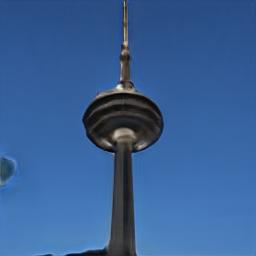

In [15]:
images[1]

In [ ]:

'''
Do not cache images on browser, see: https://stackoverflow.com/questions/34066804/disabling-caching-in-flask
'''
@app.after_request
def add_header(r):
    r.headers['Cache-Control'] = 'no-cache, no-store, must-revalidate'
    r.headers['Pragma'] = 'no-cache'
    r.headers['Expires'] = '0'
    r.headers['Cache-Control'] = 'public, max-age=0'
    return r
#

'''
TODO

Implement spectral clustering, given an affinity matrix. You are required to implement this using standard matrix computation libraries, e.g. numpy, for computing a spectral embedding.
You may use k-means once you've obtained the spectral embedding.

NOTE: the affinity matrix should _not_ be symmetric! Nevertheless, eigenvectors will be real, up to numerical precision - so you should cast to real numbers (e.g. np.real).
'''
def spectral_clustering(affinity_mat, n_clusters):
    pass
#

'''
TODO

Cluster the channels within each layer.
This should take, as arguments, the two similarity matrices derived from the IoU scores.
Specifically, the first argument is the similarity matrix between channels at layer 2 and channels at layer 3.
The second argument is the similarity matrix between channels at layer 3 and channels at layer 4.

A generalization of spectral biclustering should be performed. More details given in the assignment notebook.
'''
def multiway_spectral_clustering(sim_a2_a3, sim_a3_a4, n_clusters):
    pass
#

'''
TODO

Given a link selected from the visualization, namely the layer and clusters at the individual layers, this route should compute the mean correlation from all channels in the source layer and all channels in the target layer, for each sample.
'''
@app.route('/link_score', methods=['GET','POST'])
def link_score():
    pass
#

'''
TODO

Given a layer (of your choosing), perform max-pooling over space, giving a vector of activations over channels for each sample. Perform UMAP to compute a 2D projection.
'''
@app.route('/channel_dr', methods=['GET','POST'])
def channel_dr():
    pass
#

'''
TODO

Compute correlation strength over selected instances, those brushed by the user.
'''
@app.route('/selected_correlation', methods=['GET','POST'])
def selected_correlation():
    pass
#

'''
TODO

Compute correlation strength over all instances.
'''
@app.route('/activation_correlation_clustering', methods=['GET'])
def activation_correlation_clustering():
    pass
#

'''
TODO

In the main, before running the server, run clustering, store results in variables a2_clustering, a3_clustering, a4_clustering
'''
if __name__=='__main__':
    app.run()
#